### **📈REPLICATING AND TESTING CUSTOM MAXOUT NETWORKS.**

Hey there! This notebook is meant to compare the performance of 4 MLP models with different activation functions on the MNIST dataset.
The first of these uses the typical ReLU activation, while the remaining three use various versions of **a custom maxout activation function** (replicating the original 2013 paper https://arxiv.org/abs/1302.4389) as defined in **Maxout.py**. 

The objective of this experiment is to see whether the theoretical benefits of Maxout work in real-world use cases. As outlined in the above paper, Maxout can (arbitrarily) approximate any continuous function as it acts much like a piecewise linear approximator - this is promising, as it means that both the ReLU and Leaky ReLU activation functions are both special cases of Maxout. Logically, this should mean that maxout can learn more complex functions and thus be able to better model an existing relationship.

Practically, the function works by splitting the input vector into *i* groups of *k* neurons each. Then, it takes the **MAXIMUM** for each one of these groups - turning the group of *k* neurons into just one. So, if there are 10 neurons in total, and we split the layer into groups of 2 ($i=2$, $k=5$), then that means that activation function will map those 10 neurons **to just 2** - taking the **highest activations and capturing the relationships that appear to have the most relevance**.

This essentially means that **maxout also has its own weights as it acts much like a linear transform* - this produces more trainable parameters but also offers the opportunity for better learning.

**Mathematically:**
$h_1(x)=max_{jΣ[1, k]}z_{ij}$, where $z_{ij}=x^TW_{...ij}+b_{ij}$

**Visually:** (credit to @MlforNerds https://www.youtube.com/watch?v=DTVlyP-VihU&t=403s):

<p align = "center"><img src="./images/MAXOUT_DIAGRAM_MLFORNERDS.jpg" alt="Maxout Diagram" /></p>

### **➗Why does Maxout actually work? (The Math)**

As listed in the paper, there are ***two key principles*** that allow Maxout to (arbitrarily) approximate continuous functions. Consider the following neural network (from the original maxout paper):

<p align = "center"><img src="./images/MAXOUT_NN_DIAGRAM.jpg" alt="Maxout NN Example" /></p>

In this case, $v$ is simply the input vector of the previous layer. This is then split into two groups -> $z_1$ and $z_2$ (or $i_1$ and $i_2$ if using the notation from the above example). Each of these groups has a **single maxout activation**, specified by $h_1$ and $h_2$. The two outputs of these activations (and by extension the two groups) are fed into $g$, in essence converting $z_1$ and $z_2$ into a single output.

Let's say, theoretically, that the weights of $g$ learned to **subtract the results from $h_2$ to $h_1$** - finding the difference between both functions. In theory, this last unit **should be able to approximate ANY continuous function**, as a result of:

1. Two convex PWL (piecewise linear) functions **can be subtracted to generate ANY CONTINUOUS PWL FUNCTION**. Remember that Maxout basically approximates smooth functions in small "pieces". While this allows it to approximate convex functions, one Maxout unit alone cannot approximate any **non-convex PWL continuous function.** However, two of these convex PWL functions, when subtracted, can yield a continuous function -> meaning **that since $g(v) = h_1(v)-h_2(v)$ (since its a difference of two convex PWLs) it can approximate any continuous PWL function.**

2. If we're trying to approximate a function, then *there exists a continuous PWL function that comes arbitrarily close* - in other words, if we choose an "error" $ε$ then there will be some PWL function that will yield less than $e$ when subtracted from the original function. More simply, $|f(v)-g(v)| < ε$ - meaning that **we can approximate any continuous function from any continuous PWL function with reasonable accuracy.**

All in all, this means that the shown maxout network **can map any input/output relationship quite well, without problems!**

### **📝Methodology + This Notebook.**
Four models will be trained on Handwritten digit classification via MNIST (344k samples) - ReLU, Maxout with Bias, Maxout without Bias, and Maxout **with Dropout** (more on this in the next section).

The ReLU model will be trained via FastAI, whereas the Maxout models will use FastAI *DataLoaders* and *Learners* but PyTorch for the training loop (as the activation function has been implemented separately). In the end, **all models are tested on the same 8 000 samples** and accuracy + confusion matrices are reported.

Feel free to clone this repo and try it out for yourself! Reach out to aditya.dewan124@gmail.com, @adidewan124 on Twitter, or via LinkedIn if you have any questions or ideas.

### 🎯**Results and Outcomes.**

Interestingly, despite higher function-modelling capabilities, the Maxout network (both with and without biases and dropout) fell short by ~3% in terms of test accuracy when compared to the regular ReLU network.

My hypothesis for this is that, despite having *higher potential to model functions, the excess parameters needed to be tuned by Maxout mean that they cause the model to be more overfitting-prone.* While the model achieves low training losses, the end accuracy on the test set **ends up being lower as excess parameters make it easier to adapt directly to the dataset rather than capture the underlying relationship behind it.** This explains why Maxout, as described by the paper, **is meant to be used in conjunction with Dropout** - more regularization is needed to unlock the function's full benefits.

Surprisingly, however, the "worst" (by approximately 5 percentage points) performing model was the combination of Maxout and Dropout - in direct contradiction to the above hypothesis. I believe this is the case **as models that have dropout take significantly longer to learn the same relationships** - as parts of the network and activation functions are quite literally shut off, each part of the network becomes less prone to overfitting; this of course makes it more difficult for the network to learn relationships, but makes it more likely that the relationships learned are in better conjunction with reality.

It appears that, despite being simpler, ReLU activations **allow the rest of the network to capture more meaningful relationships due to fewer parameters and increased simplicity!**

**🔑 Key takeaway: Simplicity > Complexity for most cases** (Maxout with Dropout, while the theoretical best-solution, require more resources to achieve performance - but may be justified in cases where accuracy is paramount). 

*Special thanks to Ian Goodfellow, David Warde-Farley, Mehdi Mirza, Aaron Courville, and Yoshua Bengio for coming up with the original concept back in 2013! Check out their paper here https://arxiv.org/abs/1302.4389*

In [9]:
#For datablocks and data processing + training
import fastai
print(fastai.__version__)
from fastai.vision.all import *
#For neural networks
import torch.nn as nn
#For activation functions and layers
import torch.nn.functional as F
#Import pandas and numpy
import pandas as pd
import numpy as np

2.6.3


In [11]:
#Import handwritten digit classification dataset via untar_data
#Use a small subset of the MNISt dataset (344k samples)
dataset = untar_data(URLs.MNIST)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
torch.Size([64, 3, 28, 28])
torch.Size([64])


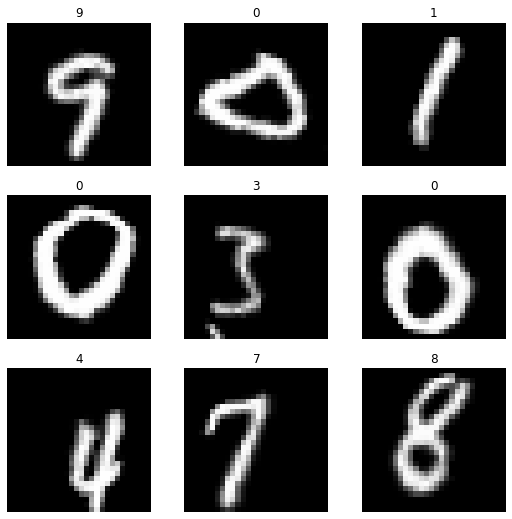

In [12]:
#Create a new datablock object (tells us preconditions for processing data)
#We pass in the respective data to the block for processing
datablock = DataBlock(
            blocks = (ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = RandomSplitter(valid_pct = 0.2, seed = 32),
            get_y = parent_label,
            batch_tfms = aug_transforms(mult = 2.0, do_flip = False))

#Create a data loader and pass in the training path -> will apply transforms and apply labels based on directories
batch_size = 64
training_dataloader = datablock.dataloaders(dataset/"training", batch_size = batch_size)
training_dataloader.train.show_batch()
sample_batch = training_dataloader.train.one_batch()

print(sample_batch[0].shape)
print(sample_batch[1].shape)

#### DEFINING MODELS.

In [13]:
#Create a ReLU and custom Maxout model and compare performance
#We have three channels in our data - they are identical as the image is black and white
n_channels = 3

#ReLU Model (ReLU is a special case of Maxout with k = 2)
ReLU_Model = nn.Sequential(
    #Flatten inputs
    nn.Flatten(),
    #Basic Linear transform - shape of input images is 28*28 and has 3 channels; thus first input will have 28*28*3 samples
    nn.Linear(28*28*n_channels, 500),
    nn.ReLU(),
    nn.Linear(500, 300),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    #Use log softmax over softmax as gradient is easier to compute -> very close to the line x - max(x)
    nn.LogSoftmax(dim=1)
)

#DEFINE CUSTOM MAXOUT MODELS
from Maxout import CustomMaxout

# WB - WITHOUT BIAS.
# B - WITH BIAS.
# D - WITH DROPOUT AND BIAS.

#Keep everything the same but add maxout activations - set bias to FALSE
Maxout_WB_Model = nn.Sequential(
    #Flatten inputs
    nn.Flatten(),
    #Basic Linear transform - shape of input images is 28*28
    nn.Linear(28*28*n_channels, 500),
    #Custom Maxout - inputs, outputs, channels, bias
    CustomMaxout(500, 400, n_channels, False),
    nn.Linear(400, 300),
    CustomMaxout(300, 200, n_channels, False),
    nn.Linear(200, 100),
    CustomMaxout(100, 50, n_channels, False),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)

#Declare another maxout model but with bias TRUE
Maxout_B_Model = nn.Sequential(
    #Flatten inputs
    nn.Flatten(),
    #Basic Linear transform - shape of input images is 28*28
    nn.Linear(28*28*n_channels, 500),
    #Same principal - but, bias is set to True (meaning that there are more parameters to tune)
    CustomMaxout(500, 400, n_channels, True),
    nn.Linear(400, 300),
    CustomMaxout(300, 200, n_channels, True),
    nn.Linear(200, 100),
    CustomMaxout(100, 50, n_channels, True),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)

#Define dropout probability (0.2)
drop_prob = 0.2
Maxout_D_Model = nn.Sequential(
    #Flatten inputs
    nn.Flatten(),
    nn.Linear(28*28*n_channels, 500),
    CustomMaxout(500, 400, n_channels, True),
    #Dropout Layer - as Maxout rapidly increases the parameters of a nn, increased regularization is needed to exceed baseline performance
    #The Maxout paper itself recommends using Maxout in conjunction with Dropout for the best results; we'll be testing this
    nn.Dropout(drop_prob),
    nn.Linear(400, 300),
    CustomMaxout(300, 200, n_channels, True),
    #Include a dropout layer after every Maxout activation
    nn.Dropout(drop_prob),
    nn.Linear(200, 100),
    CustomMaxout(100, 50, n_channels, True),
    nn.Dropout(drop_prob),
    nn.Linear(50, 10),
    #Use log softmax over softmax as gradient is easier to compute -> very close to the line x - max(x)
    nn.LogSoftmax(dim=1)
)

SuggestedLRs(valley=0.0006918309954926372)


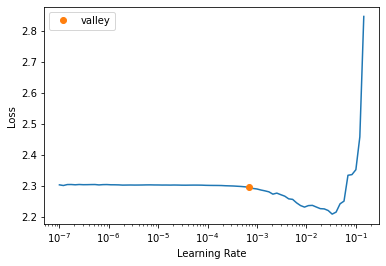

In [14]:
#Create learner for ReLU model
ReLU_learner = Learner(training_dataloader, ReLU_Model, metrics = accuracy)
#Graph learning rates - plot the minimum, steep, valley, and slide
ReLU_optimalLR = ReLU_learner.lr_find()
print(ReLU_optimalLR)

epoch,train_loss,valid_loss,accuracy,time
0,0.415325,0.188314,0.941833,05:37


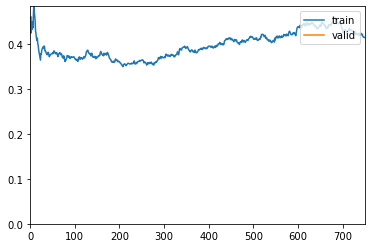

epoch,train_loss,valid_loss,accuracy,time
0,0.284557,0.117427,0.963083,05:37
1,0.281036,0.118861,0.962167,04:24
2,0.249923,0.118378,0.964333,03:33
3,0.244258,0.099587,0.969917,03:32
4,0.228714,0.091881,0.973333,04:11
5,0.187598,0.080824,0.974667,04:16
6,0.162744,0.064349,0.981000,04:31
7,0.144693,0.059128,0.981917,03:51
8,0.138330,0.057244,0.982333,03:53
9,0.133055,0.055179,0.983333,04:34


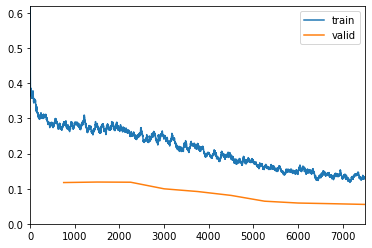

In [16]:
#Extract optimal learning rate for relu model
float_rlu_optimal_lr = ReLU_optimal_lr[0]
#Fit and train model
epochs = 10 
#Callback at the end produces graph of loss
ReLU_learner.fine_tune(epochs, float_rlu_optimal_lr, cbs = [ShowGraphCallback()])

In [17]:
#Save model
ReLU_learner.save("ReLU_Model")

Path('models/ReLU_Model.pth')

#### TRAINING MAXOUT MODELS - WITH BIAS, WITHOUT BIAS, AND DROPOUT (WITH BIAS).

SuggestedLRs(valley=0.00019054606673307717)


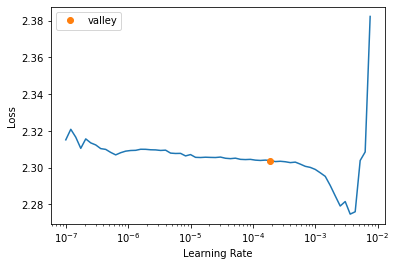

In [18]:
#Create learner object
Maxout_WB_learner = Learner(training_dataloader, Maxout_WB_Model, metrics = "accuracy", cbs = [ShowGraphCallback()])
#Find ideal learning rate
Maxout_WB_optimalLR = Maxout_WB_learner.lr_find()
print(Maxout_WB_optimalLR)

SuggestedLRs(valley=0.00013182566908653826)


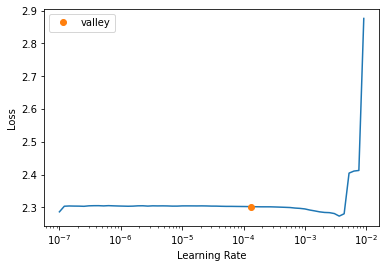

In [19]:
#Create learner object
Maxout_B_learner = Learner(training_dataloader, Maxout_B_Model, metrics = "accuracy", cbs = [ShowGraphCallback()])
#Find ideal learning rate
Maxout_B_optimalLR = Maxout_B_learner.lr_find()
print(Maxout_B_optimalLR)

SuggestedLRs(valley=0.0002290867705596611)


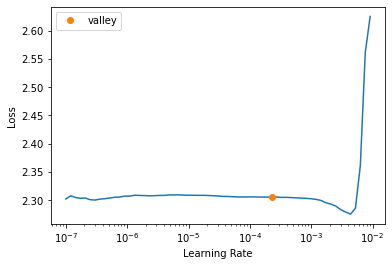

In [23]:
#Find learning rate for dropout model
Maxout_D_learner = Learner(training_dataloader, Maxout_D_Model, metrics = "accuracy", cbs = [ShowGraphCallback()])
#Find ideal learning rate
Maxout_D_optimalLR = Maxout_D_learner.lr_find()
print(Maxout_D_optimalLR)

In [24]:
#Begin training fastai learner
#One of the key benefits of fastai is customization. As we have a custom activation function, some Recorder functionality in the fastai library does not work as intended.
#To solve this, we can write our own training loop in native PyTorch.

#Import matplotlib to display training graph and update as epochs progress
import matplotlib.pyplot as plt
%matplotlib inline

#List of all models - all other variable names are derived from these models (i.e. (model1)_learner, (model1)_y_true)
model_list = ["ReLU", "Maxout_WB", "Maxout_B", "Maxout_D"]

#Define a) learning rate as a float (FastAI returns it as a 1 dim tensor) and b) declare optimizer
def defineParams(model):
    globals()[model + "optimalLR_float"] = globals()[model + "_optimalLR"][0]
    #Use ADAM optimizer for consistency with ReLU model
    globals()[model + "_learner"].opt = Adam(globals()[model + "_learner"].parameters(), globals()[model + "optimalLR_float"])
#Define parameters
[defineParams(m) for m in model_list[1:]]

#Train model function
def train_model(learner, n_epochs, train_iters, valid_iters):
    #Train losses
    train_losses = []
    #Validation losses
    valid_losses = []
    #Array of epochs (for plotting the graph at the end of training)
    epochs = []

    #Iterate over epochs
    for epoch in range(n_epochs):
        #Iterate over each "minibatch" in batch (each sample in batch, batch size declared while we were using the dataloader)
        #This is for TRAINING data
        train_loop(learner, train_iters, train_losses, epoch, epochs)
        #Same process but with validation data and WITHOUT computing gradients
        valid_loop(learner, valid_iters, valid_losses)
    
    #If we are on the last epoch, return the average loss for the entire training session and create a graph of training and validation losses
    if epoch == n_epochs - 1:
        #Change figure size
        plt.figure(figsize = (8, 6))
        #Plot train and validation losses
        plt.plot(epochs, train_losses, label = "TRAIN")
        plt.plot(epochs, valid_losses, label = "VALIDATION")
        #Set titles
        plt.xlabel("EPOCH")
        plt.ylabel('LOSS')
        plt.title("MAXOUT MODEL - TRAINING AND VALIDATION LOSSES.")
        #Create a legend and show graph
        plt.legend()
        plt.show()

#Train loop for a single epoch
def train_loop(learner, train_iters, train_losses, epoch, epochs):
    #Set training epoch loss to zero
    train_epoch_loss = 0.0
    #Iterate over training data
    for batch_index, batch_data in enumerate(learner.dls.train, 0):
        #Get data inputs and labels
        data_inputs, data_labels = batch_data
        #Set gradient to zero
        learner.zero_grad()
        #Make predictions (learner.model)
        preds = learner.model(data_inputs)
        #Calculate loss
        calc_loss = learner.loss_func(preds, data_labels)
        #Calculate gradients
        calc_loss.backward()
        #Use gradients to take a "step" with the optimizer - optimizer is, by default, set to Adam
        learner.opt.step()
        #Append loss - .item() converts scalar to regular float
        train_epoch_loss += calc_loss.item()
        #Check if we are on the last iteration of the minibatch
        if batch_index == train_iters - 1:
            avg_epoch_loss = train_epoch_loss/train_iters
            train_losses.append(avg_epoch_loss)
            epochs.append(epoch + 1)
            print("EPOCH [{}] TRAINING LOSS: {}".format(epoch + 1, avg_epoch_loss))
            #Stop the loop 
            break

#Validation loop for a single epoch
def valid_loop(learner, valid_iters, valid_losses):
    #Set validation loss to zero
    valid_epoch_loss = 0.0
    #Iterate over validation samples
    for valid_batch_index, valid_batch_data in enumerate(learner.dls.valid, 0):
        #Get x inputs and y labels
        valid_inputs, valid_labels = valid_batch_data
        #Get predictions
        val_preds = learner.model(valid_inputs)
        #Calculate validation loss
        val_loss = learner.loss_func(val_preds, valid_labels)
        #Append loss
        valid_epoch_loss += val_loss.item()
        #If on the last iteration of minibatch, print loss and save best model
        if valid_batch_index == valid_iters - 1:
            avg_val_loss = valid_epoch_loss/valid_iters
            valid_losses.append(avg_val_loss)
            print("VALIDATION LOSS: {}".format(avg_val_loss))

EPOCH [1] TRAINING LOSS: 0.7292311487992604
VALIDATION LOSS: 0.28682384729385374
EPOCH [2] TRAINING LOSS: 0.4730431707302729
VALIDATION LOSS: 0.19886194705963134
EPOCH [3] TRAINING LOSS: 0.39393509193261467
VALIDATION LOSS: 0.1840494902431965
EPOCH [4] TRAINING LOSS: 0.35080582402149835
VALIDATION LOSS: 0.14306614715605975
EPOCH [5] TRAINING LOSS: 0.3145756204823653
VALIDATION LOSS: 0.1571316672116518
EPOCH [6] TRAINING LOSS: 0.2932680302460988
VALIDATION LOSS: 0.13387144025415182
EPOCH [7] TRAINING LOSS: 0.2723684365351995
VALIDATION LOSS: 0.12167629271745682
EPOCH [8] TRAINING LOSS: 0.2621143926580747
VALIDATION LOSS: 0.13855159293860198
EPOCH [9] TRAINING LOSS: 0.24829426196217536
VALIDATION LOSS: 0.10243323680013418
EPOCH [10] TRAINING LOSS: 0.24022699278096357
VALIDATION LOSS: 0.09487039815634489


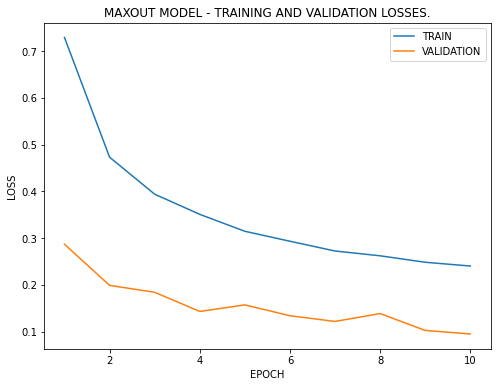

In [26]:
#Train the Maxout models (without bias)
#Total epochs will be 10, and training iterations will be 750 and 50 respectively (using the same # of iterations as the ReLU model)
train_model(learner = Maxout_WB_learner, n_epochs = 10, train_iters = 750, valid_iters = 50)

In [27]:
#Save Maxout model (without bias)
Maxout_WB_learner.save("Maxout_WB_Model")

Path('models/Maxout_WB_Model.pth')

EPOCH [1] TRAINING LOSS: 1.2623714292844137
VALIDATION LOSS: 0.44069181084632875
EPOCH [2] TRAINING LOSS: 0.6384548414150873
VALIDATION LOSS: 0.2779819968342781
EPOCH [3] TRAINING LOSS: 0.4851772368748983
VALIDATION LOSS: 0.20500323802232742
EPOCH [4] TRAINING LOSS: 0.4092070794502894
VALIDATION LOSS: 0.17630425751209258
EPOCH [5] TRAINING LOSS: 0.36215244643886885
VALIDATION LOSS: 0.18197616711258888
EPOCH [6] TRAINING LOSS: 0.3282258113423983
VALIDATION LOSS: 0.16159541741013528
EPOCH [7] TRAINING LOSS: 0.3002926664153735
VALIDATION LOSS: 0.13213765066117047
EPOCH [8] TRAINING LOSS: 0.28222837359209857
VALIDATION LOSS: 0.12845431409776212
EPOCH [9] TRAINING LOSS: 0.2638839848836263
VALIDATION LOSS: 0.11626705270260572
EPOCH [10] TRAINING LOSS: 0.25153289519747096
VALIDATION LOSS: 0.10882409835234284


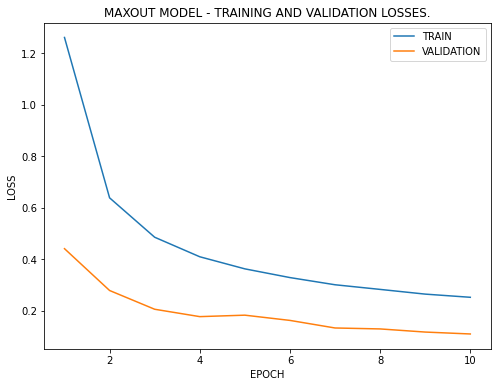

In [28]:
#Train the Maxout models (with bias)
#Total epochs will be 10, and training iterations will be 750 and 50 respectively (using the same # of iterations as the ReLU model)
train_model(learner = Maxout_B_learner, n_epochs = 10, train_iters = 750, valid_iters = 50)

In [29]:
#Save Maxout model (with bias)
Maxout_B_learner.save("Maxout_B_Model")

Path('models/Maxout_B_Model.pth')

EPOCH [1] TRAINING LOSS: 1.16579405216376
VALIDATION LOSS: 0.4077025577425957
EPOCH [2] TRAINING LOSS: 0.6055373674035073
VALIDATION LOSS: 0.2531306692957878
EPOCH [3] TRAINING LOSS: 0.484522975564003
VALIDATION LOSS: 0.2269952890276909
EPOCH [4] TRAINING LOSS: 0.42294044329722724
VALIDATION LOSS: 0.19595682010054588
EPOCH [5] TRAINING LOSS: 0.38213305350144705
VALIDATION LOSS: 0.17838216871023177
EPOCH [6] TRAINING LOSS: 0.3574310518105825
VALIDATION LOSS: 0.18633492290973663
EPOCH [7] TRAINING LOSS: 0.332657618890206
VALIDATION LOSS: 0.16271564692258836
EPOCH [8] TRAINING LOSS: 0.3101572586596012
VALIDATION LOSS: 0.13308388751000166
EPOCH [9] TRAINING LOSS: 0.30444542261461416
VALIDATION LOSS: 0.13548599317669868
EPOCH [10] TRAINING LOSS: 0.2924726982712746
VALIDATION LOSS: 0.13778638917952776


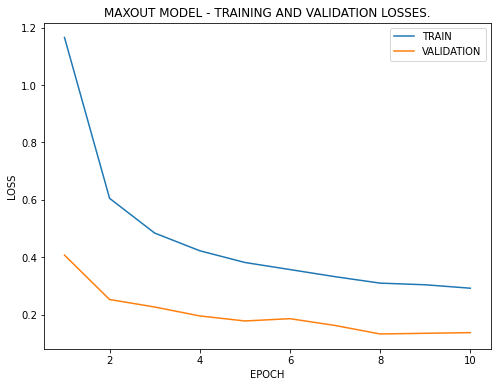

In [30]:
#Train Dropout Model
train_model(learner = Maxout_D_learner, n_epochs = 10, train_iters = 750, valid_iters = 50)

In [31]:
#Save Maxout model (with bias)
Maxout_D_learner.save("Maxout_D_Model")

Path('models/Maxout_D_Model.pth')

#### COMPARING PERFORMANCE + MODEL VALIDATION.

In [ ]:
#Load all models (learner object is being created again to avoid running all previous training and lr_find cells)
#Declare Learners dynamically
def declareLearners(model):
    globals()[model + "_learner"] = Learner(training_dataloader, globals()[model + "_Model"], metrics = accuracy)
    globals()[model + "_learner"].load(model + "_Model")

[declareLearners(model) for model in model_list]

In [41]:
#Define new datablock for validation data - to create a new dataloader for testing
#Set splitter and transforms to None as we do not want to split or augment the dataset

validationDatablock = DataBlock(
            blocks = (ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = None,
            get_y = parent_label,
            batch_tfms = None)

#Create new dataloader -> set shuffle to false and do not drop the last batch
valid_data = datablock.dataloaders(dataset/"testing", batch_size = 64, shuffle_train = False, drop_last = False)
#Use .train to access testing images -> this is simply as the testing images have been shuffled into the .train directory via fastai by default
#Use .tee to create 4 ITERATORS - one for testing each model
import itertools
ReLU_valid_loader, Maxout_WB_valid_loader, Maxout_B_valid_loader, Maxout_D_valid_loader = itertools.tee(valid_data.train, 4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [42]:
#Evaluate perfromance based on 8000 samples from validation dataset (obtained from training dataloader)
#A seperate test set in this case is not required; gradients were off during validation and thus the model did not "learn" during those portions

#Use sci-kit learn to generate a confusion matrix and seaborn to plot 
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Declare true and prediction arrays for all three models

TRUE_AND_PREDS = {}
def assignValidationArrays(model):
    TRUE_AND_PREDS[model] = {"y_true" : [], "y_preds" : []}

#Populate True and Preds dictionary
[assignValidationArrays(m) for m in model_list]

#TensorImages (found in the dataloader) are a custom FastAi datatype that have no equivalent to .index - this functionality is needed to extract categories from predictions
#This function simply iterates and returns the needed index; as it will only be iterating over 10 samples this is sufficient 
def findTensorImageIndex1D(tensor, val):
    for i, obj in enumerate(tensor):
        if obj == val:
            return i

#Generate prediction and label array - for determining accuracy and plotting confusion matrix
def generatePredictions(learner, y_true, y_preds, validation_data):
    #This loop iterates over each batch, feeds to the model, and generates labels and predictions
    #As we require 8000 validation samples per learner, this loop must be executed (8000/64) 125 times
    for i in range(125):
        #Gets one BATCH (size 64) of inputs and labels
        inputs, labels = next(validation_data)
        #Add labels to y_true
        y_true.extend([*labels])
        #Passes one batch into Maxout model and obtains predictions
        predictions = learner.model(inputs)
        #Converts predictions into categories -> predictions are continous and thus must be processed to get categories
        for pred_distribution in predictions:
            pred_class = findTensorImageIndex1D(pred_distribution, max(pred_distribution))
            y_preds.append(pred_class)

#Generate predictions for each model
for model in model_list:
    generatePredictions(learner = globals()[model + "_learner"], y_true = TRUE_AND_PREDS[model]["y_true"], y_preds = TRUE_AND_PREDS[model]["y_preds"],
                        validation_data = globals()[model + "_valid_loader"])

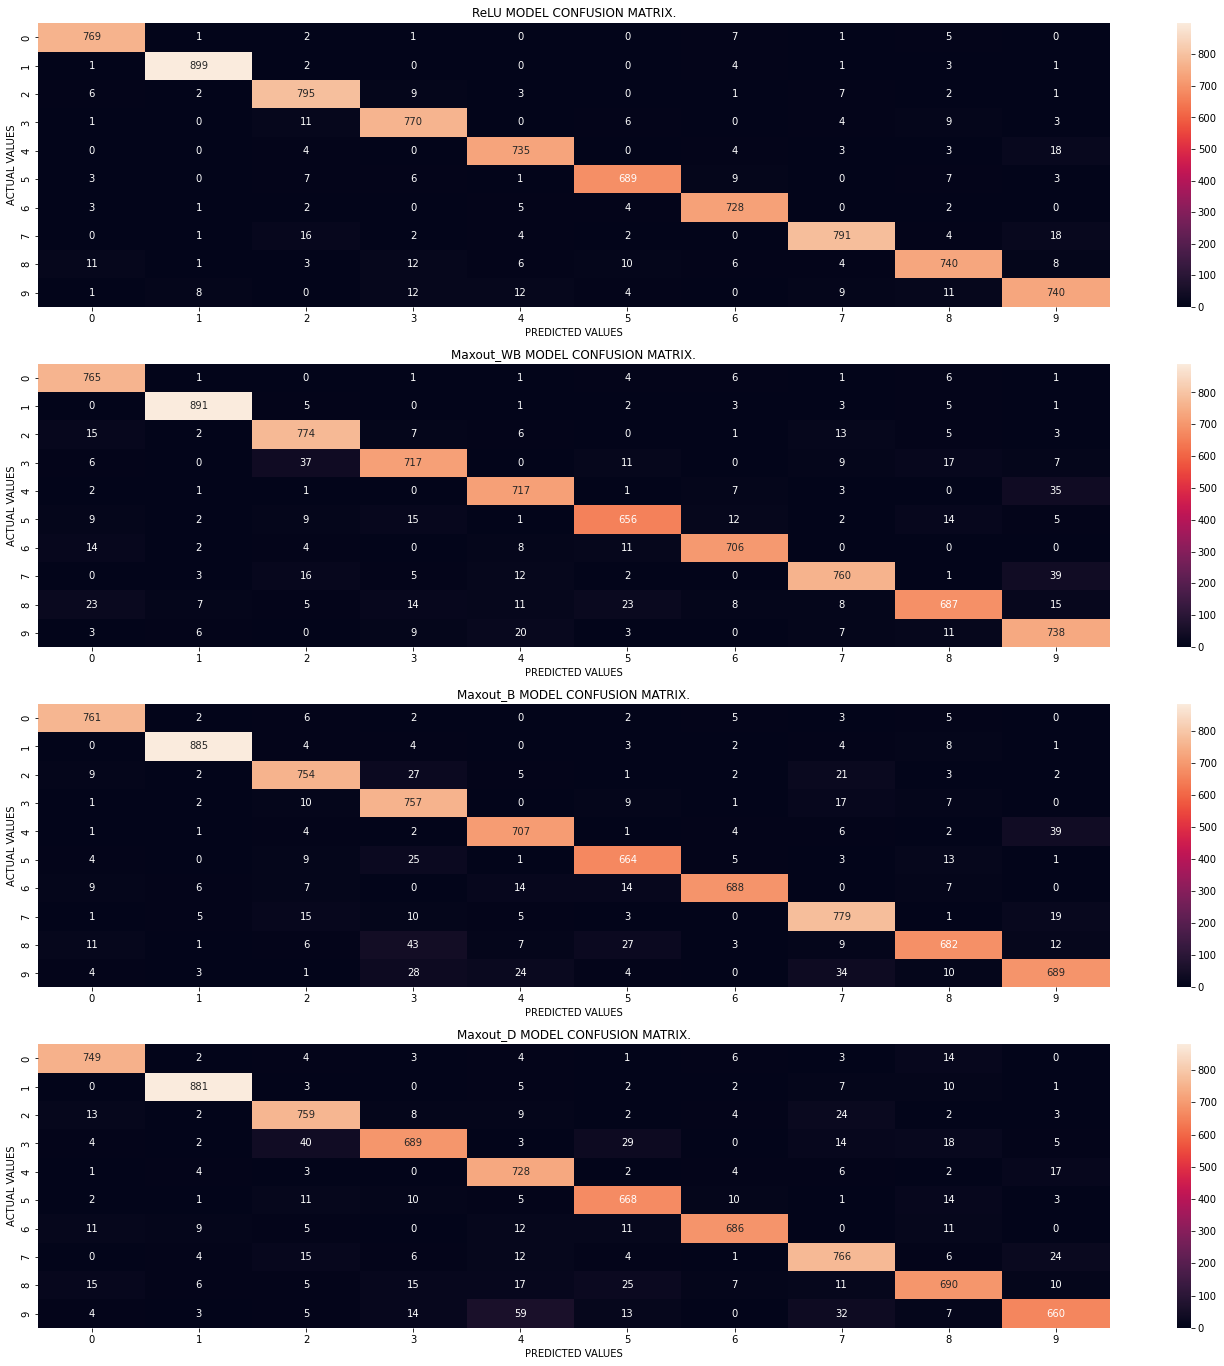

In [50]:
#Generate heatmaps and confusion matricies for each model
fig, (ReLU_ax, Maxout_WB_ax, Maxout_B_ax, Maxout_D_ax) = plt.subplots(4, 1, figsize = (24, 24))
#Heatmap plotter 
def plotHeatmaps(model):
    #Use ScikitLearn to generate a 2D confusion matrix
    globals()[model + "_confusion_matrix"] = confusion_matrix(TRUE_AND_PREDS[model]["y_true"], TRUE_AND_PREDS[model]["y_preds"])
    #Feed into seaborn to plot heatmap
    globals()[model + "_heatmap"] = sns.heatmap(globals()[model + "_confusion_matrix"], annot = True, fmt = "g", ax = globals()[model + "_ax"])
    #Set chart title, x axes, and y axes
    globals()[model + "_ax"].set_title(model + " MODEL CONFUSION MATRIX.")
    globals()[model + "_ax"].set_xlabel("PREDICTED VALUES")
    globals()[model + "_ax"].set_ylabel("ACTUAL VALUES")

[plotHeatmaps(m) for m in model_list]
plt.show()

In [51]:
#Define accuracy function
def calculateAccuracy(labels, preds):
    total_correct = 0
    #Find number of correct predictions
    [total_correct := total_correct + 1 for label, pred in zip(labels, preds) if label == pred]
    #Find accuracy
    accuracy = total_correct/len(labels)
    return accuracy
#Define accuracy getter function
def getAccuracy(model):
    globals()[model + "_accuracy"] = calculateAccuracy(TRUE_AND_PREDS[model]["y_true"], TRUE_AND_PREDS[model]["y_preds"])
#Get accuracies of all 4 models
[getAccuracy(m) for m in model_list]

#Print
print("RELU MODEL ACCURACY:", ReLU_accuracy)
print("CUSTOM MAXOUT MODEL ACCURACY (WITHOUT BIAS):", Maxout_B_accuracy)
print("CUSTOM MAXOUT MODEL ACCURACY (WITH BIAS):", Maxout_WB_accuracy)
print("CUSTOM MAXOUT MODEL ACCURACY (DROPOUT, WITH BIAS):", Maxout_D_accuracy)

RELU MODEL ACCURACY: 0.957
CUSTOM MAXOUT MODEL ACCURACY (WITHOUT BIAS): 0.92075
CUSTOM MAXOUT MODEL ACCURACY (WITH BIAS): 0.926375
CUSTOM MAXOUT MODEL ACCURACY (DROPOUT, WITH BIAS): 0.9095
